In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Bragg Grating/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Bragg Grating/SimulationFiles/'))
spec_win.loader.exec_module(lumapi)

In [2]:
bragg = lumapi.MODE(filename='BRAGGProjectEME.lms',hide=False) 

## Functions

In [3]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

## Assembly parameters

In [94]:
SilH = 450e-9 # Silicon height
SilW = 220e-9 # Silicon width
GlassH = 2e-6 # SiO2 height
ExtH = 475e-9 # Extremities height

neff = 2.345             
ng = 4.454 

L = 40e-6                   # Placeholder value

fwhm = 20e-9                # FWHM
lmbd = 1500e-9

kappa = np.sqrt( (fwhm*np.pi*ng/(lmbd**2))**2  - (np.pi/L)**2 )
Rmax = (np.tanh(kappa*L))**2
delN = kappa*lmbd/2         # deltaNeff (For stepwise neff)

sym.init_printing()
Vh = sym.symbols('Vh')
func = sym.Eq(0.032973 + 1.543951e6*Vh - 2.044362e12*Vh**2 + 9.477402*Vh**3,delN)
f = sym.solve([func],(Vh))
Vh = float(f[0][0])/2        # DeltaW / 2

Vp = (lmbd/(2*neff))/2       # Half grating period
VpNum = int((L/(2*Vp)) - 2)

display(Math('\kappa = %5.2f,~~~~~ \Delta W / 2 = %5.2f nm,~~~~~ L = %5.2f um,~~~~~ R_{max} = %5.2f' %(kappa,Vh*1e9,L*1e6,Rmax)))
display(Math('\Lambda = %5.2fum,~~~~~ N = %5.0f' %(2*Vp*1e6,VpNum)))

dellmbd = (1500e-9)**2/(ng*np.pi) * np.sqrt(kappa**2 + (np.pi/L)**2)
Rmax = (np.tanh(kappa*L))**2

display(Math('\Lambda = %5.2fum,~~~~~ N = %5.0f' %(2*Vp*1e6,VpNum)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Assembly main model

In [51]:
bragg.switchtolayout()
bragg.deleteall()

# Substract insert
RectInsert(1*Vp, 2*Vp + 4e-6, 0, GlassH*2, -(SilW+GlassH)/2, GlassH, "SiO2 (Glass) - Palik", bragg)
bragg.set("name", "Substract")

# Waveguide insert
RectInsert(1.5*Vp, Vp, 0, SilH, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "Waveguide")

# Extremities insert
RectInsert(-1e-6, 2e-6, 0, ExtH, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "W1")
RectInsert(2*Vp+1e-6, 2e-6, 0, ExtH, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "W2")

# Corrugation insert
RectInsert(Vp/2, Vp, 0, ExtH+2*Vh, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "Teeth")

# EME setting
bragg.addeme()

bragg.set({"y":0, "y span":(ExtH+2*Vh)*3, "z":0, "z span":2e-6, "x min": -1.5e-6,
         "display cells":1, "number of cell groups":4, "number of modes for all cell groups":2,
         "group spans": np.transpose([(1.5e-6, Vp, Vp, 1.5e-6)]),
         "cells":np.transpose([2, 2, 2, 2]),
         "subcell method":np.transpose([1, 1, 1, 1]), # 0 = none,  1 = CVCS
         "number of periodic groups":3})

bragg.set({"start cell group":np.transpose([1,2,4]), "end cell group":np.transpose([1,3,4]), "periods":np.transpose([1,VpNum,1]),
           "wavelength":lmbd,
           "mesh cells y": 200, "mesh cells z": 200,
           "y min bc":"PML", "y max bc":"PML", "z min bc":"PML", "z max bc":"PML"})

# EME Ports setting
bragg.selectpartial("EME::Ports::port")
bragg.delete()

bragg.addemeport()
bragg.set({"use full simulation span":0,
"port location":"left",
"y":0, "y span":3*(Vh+SilH),
"z":0, "z span":1e-6})

bragg.addemeport()
bragg.set({"use full simulation span":0,
"port location":"right",
"y":0, "y span":3*(Vh+SilH),
"z":0, "z span":1e-6})

## Main model test

In [100]:
bragg.switchtolayout()
bragg.select("EME")
bragg.run()
bragg.emepropagate()

bragg.setemeanalysis("wavelength sweep",1)
bragg.setemeanalysis("start wavelength",1.47e-6)
bragg.setemeanalysis("stop wavelength",1.53e-6)
bragg.setemeanalysis("number of wavelength points",2000)
bragg.emesweep("wavelength sweep")

SWvMatrix = bragg.getemesweep("S_wavelength_sweep")
A = bragg.getresult("EME","user s matrix")

dict_keys(['wavelength', 's11', 's21', 's12', 's22', 'Lumerical_dataset'])
{'index': [1372, 1846], 'yMed': 0.4885153537432743}


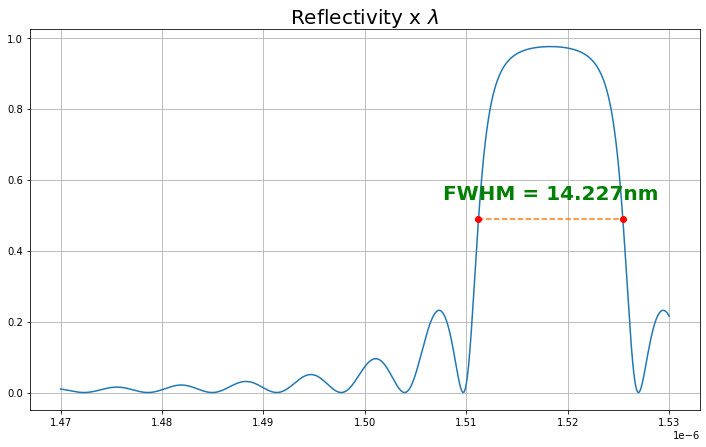

In [101]:
print(SWvMatrix.keys())

yaxis = abs(SWvMatrix['s11'])**2
xaxis = SWvMatrix['wavelength']

plt.figure(figsize=(12, 7))
plt.plot(SWvMatrix['wavelength'],abs(SWvMatrix['s11'])**2)
plt.title(r"Reflectivity x $\lambda$",fontsize=20)
plt.grid()

pnts = signalLv(abs(SWvMatrix['s11'])**2,0.5,"linear")
xcoords = pnts['index']
average = pnts['yMed']

diff = abs(xaxis[xcoords[1]] - xaxis[xcoords[0]])
plt.plot([xaxis[xcoords[0]],xaxis[xcoords[1]]], [average,average],linestyle='--')
plt.text((xaxis[xcoords[0]] + xaxis[xcoords[1]])/2,  average+0.1, 'FWHM = {:.3f}nm'.format(diff[0]*1e9), color='g', weight='black', fontsize =20, horizontalalignment='center',
verticalalignment='top')
for i in range(len(xcoords)):
    plt.plot(xaxis[xcoords[i]], average,'o',color='r')
print(pnts)

{'index': [1372, 1846], 'yMed': -15.543952036477611}


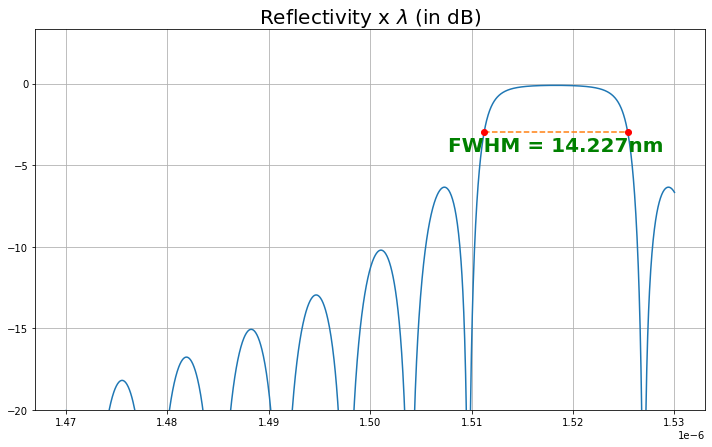

In [104]:
yaxis = 10*np.log10(abs(SWvMatrix['s11'])**2)
xaxis = SWvMatrix['wavelength']

plt.figure(figsize=(12,7))
plt.plot(SWvMatrix['wavelength'],10*np.log10(abs(SWvMatrix['s11'])**2))
plt.title(r"Reflectivity x $\lambda$ (in dB)",fontsize=20)
plt.ylim(bottom=-20)
plt.grid()

pnts = signalLv(10*np.log10(abs(SWvMatrix['s11'])**2),0.5,"log10")
xcoords = pnts['index']
average = -3

diff = abs(xaxis[xcoords[1]] - xaxis[xcoords[0]])
plt.plot([xaxis[xcoords[0]],xaxis[xcoords[1]]], [average,average],linestyle='--')
plt.text((xaxis[xcoords[0]] + xaxis[xcoords[1]])/2,  average-0.2, 'FWHM = {:.3f}nm'.format(diff[0]*1e9), color='g', weight='black', fontsize =20, horizontalalignment='center',
verticalalignment='top')
for i in range(len(xcoords)):
    plt.plot(xaxis[xcoords[i]], average,'o',color='r')
print(pnts)

## Bragg wavelength x Grating Period

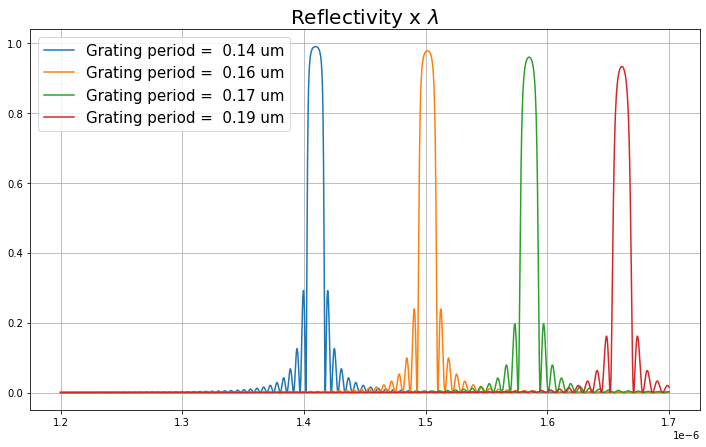

In [120]:
# Iteration stage -------------------------------------------

gpRange = [0.14e-6, 0.19e-6]   # Grating period range
gpPoints = 4                  # Grating period points

Vpi = np.linspace(gpRange[0],gpRange[1],gpPoints)

plt.figure(figsize=(12, 7))
plt.title(r"Reflectivity x $\lambda$",fontsize=20)

for i in range(gpPoints):
    bragg.switchtolayout()
    # Assembly stage --------------------------------------------

    L = 40e-6
    VpNum = int((L/(2*Vpi[i])) - 2)

    # Substract setting
    bragg.select("Substract")
    bragg.set({"x":Vpi[i], "x span":2*Vpi[i] + 4e-6})

    # Waveguide setting
    bragg.select("Waveguide")
    bragg.set({"x":1.5*Vpi[i], "x span":Vpi[i]})

    # Extremities setting
    bragg.select("W2")
    bragg.set({"x":2*Vpi[i]+1e-6})

    # Corrugation setting
    bragg.select("Teeth")
    bragg.set({"x":Vpi[i]/2, "x span":Vpi[i]})

    # EME setting
    bragg.select("EME")
    bragg.set({"group spans": np.transpose([(1.5e-6, Vpi[i], Vpi[i], 1.5e-6)])})
    bragg.set({"periods":np.transpose([1,VpNum,1])})

    # Exibition stage --------------------------------------------
    bragg.select("EME")
    bragg.run()
    bragg.emepropagate()

    bragg.setemeanalysis("wavelength sweep",1)
    bragg.setemeanalysis("start wavelength",1.2e-6)
    bragg.setemeanalysis("stop wavelength",1.7e-6)
    bragg.setemeanalysis("number of wavelength points",3000)
    bragg.emesweep("wavelength sweep")

    SWvMatrix = bragg.getemesweep("S_wavelength_sweep")
    A = bragg.getresult("EME","user s matrix")

    yaxis = abs(SWvMatrix['s11'])**2
    xaxis = SWvMatrix['wavelength']

    plt.plot(SWvMatrix['wavelength'],abs(SWvMatrix['s11'])**2,label="Grating period = {:5.2f} um".format(Vpi[i]*1e6))

    pnts = signalLv(abs(SWvMatrix['s11'])**2,0.5,"linear")
    xcoords = pnts['index']
    average = pnts['yMed']

    diff = abs(xaxis[xcoords[1]] - xaxis[xcoords[0]])

plt.legend(fontsize=15)
plt.grid()